In [243]:
%run BomInfo-Util.ipynb

In [244]:
import json
import glob
import csv
import os
from pathlib import Path

In [245]:
def depth_bom(node, level=1, branches = []):
    """
    For each branch in the operation network identifies its length
    :param node: a tree node
    :param level: current node level
    :param branches: a list to store all  branches depth
    :return:
    """
    if 'children' not in node:
        branches.append(level)
        return
    nodes = node['children']
    if len(nodes) == 0:
        branches.append(level)
        return
    for node in nodes:
         depth_bom(node, level + 1, branches=branches)


In [275]:
def branching_bom(node, branching={}):
    """
    For each node in the operation network identifies the direct number of predecessors
    :param node: current node
    :param branching: a list to store all nodes direct predecessors
    :return:
    """
    if 'children' not in node:
        return
    
    nodes = node['children']
    if len(nodes) > 0:
        operation_id = node['operationid']
        branching[operation_id] = len(nodes)
    for nod in nodes:
         branching_bom(nod, branching)


In [276]:
def nodes_level(node, levels={}, level=1):
    operation_id = node['operationid']
    if level != 1:
        if level not in levels:
            levels[level] = {operation_id}
        else:
            levels[level].add(operation_id)
    if 'children' not in node:
        return 
    nodes = node['children']
    for nod in nodes:
        nodes_level(nod, levels, level +1)

In [277]:
def assembly_production_nodes(node, assembly=0, production=0):
    """
    Count how many assembly and production nodes are in the product operation network. An assembly node has at
    least 2 direct predecessors
    :param node: current node
    :param assembly: number of assembly nodes found so far
    :param production: number of production nodes found so far
    :return: the pair (assembly, production) nodes
    """
    if 'children' not in node:
        production = production + 1
        return assembly, production
    nodes = node['children']
    if len(nodes) == 0:
        production = production + 1
        return assembly, production
        
    if len(nodes) == 1:
        production = production + 1
    else:
        assembly += 1
    for nod in nodes:
        a, p = assembly_production_nodes(nod, 0, 0)
        assembly += a
        production += p

    return assembly, production

In [278]:
def get_operation_machine(node, operation_machines={}):
    """
    Function constructs a dictionary with opperations and machine (needed for dafjs and yfjs structures)
    param: node - current node
    param: operation_machines - the dictionary 
    """
    
    if 'machines' in node:
        operation_id = node['operationid']
        operation_machines[operation_id] = node['machines']
    if 'children' not in node:
        return
    nodes = node['children']
    if len(nodes) == 0:
        return
    for nod in nodes:
        get_operation_machine(nod, operation_machines)    

    
    
def operation_characteristics(node, operation_machines={}, operation_setup_time={}, operation_execution_time={}, 
                               operation_acctual_execution_time={}, parent_quantity = 0,
                              metainfo=None,
                             dictionary_operation_machines={}):
    """
    For each operation identifies the number of machines on which the operation can be executed from a product in the
    operation network
    :param node: current node
    :param operation_machines: a list to store for each node the number of machines on which can be executed
    :param operation_setup_time: a  dictionary that stores for each machine a list with the setup time value for the products produced on it
    :param operation_execution_time: a  dictionary that stores for each machine a list with the executionTime for the products produced on it
    :return:
    """
    operation_id = node['operationid']
    # print('operation_id', operation_id)
    if parent_quantity == 0:
        quantity = 1
    else:
        quantity = parent_quantity * node['quantity']
        
    if metainfo is None:
        #machines_list = node['machines']
        machines_list = dictionary_operation_machines[operation_id]
    else:
        product_machines = metainfo['prod_machines']
        product_id = node['productid']
        for el in product_machines:
            if el['productid'] == product_id:
                machines_list = el['machines']
                
    for machine in machines_list:
        id = machine['id']
        setup_time = machine['setup_time']
        execution_time = machine['execution_time']
        acctual_execution_time = setup_time + execution_time * quantity
        if acctual_execution_time != 0: #ignore fictive node
            operation_machines[operation_id] = len(machines_list)
            if operation_id not in operation_setup_time:
                operation_setup_time[operation_id] = [setup_time]
                operation_execution_time[operation_id] = [execution_time]
                operation_acctual_execution_time[operation_id] = [acctual_execution_time]
            else:
                operation_setup_time[operation_id].append(setup_time)
                operation_execution_time[operation_id].append(execution_time)
                operation_acctual_execution_time[operation_id].append(acctual_execution_time)

    if 'children' not in node:
        return
    nodes = node['children']
    if len(nodes) == 0:
        return
    for nod in nodes:
        operation_characteristics(nod, operation_machines, operation_setup_time, operation_execution_time, operation_acctual_execution_time, quantity,
                                  metainfo, dictionary_operation_machines=dictionary_operation_machines)    


In [279]:
def get_product_machine(node, product_machines={}, operations_machine={}):
    """
    Function constructs a dictionary with products and machine (needed for dafjs and yfjs structures)
    param: node - current node
    param: product_machines - the dictionary 
    """
    operation_id = node['operationid']
    if 'machines' in node:
        product_id = node['productid']
        product_machines[product_id] = node['machines']
        operations_machine[operation_id] = node['machines']

    if 'children' not in node:
        return
    nodes = node['children']
    if len(nodes) == 0:
        return
    for nod in nodes:
        get_product_machine(nod, product_machines, operations_machine)
    
def machine_characteristics(node, machine_operation={}, machine_setup_time={}, machine_execution_time={}, 
                            machine_acctual_execution_time={}, parent_quantity=0,
                            metainfo=None,
                           dictionary_product_machines={}):
    """
    For each machines colects inforrmation regardding: operation no. executed onn it, executions time, setup time
    :param node: current node
    :param machine_operation: a dictionary  that contains the number of operations that can be executed  on a
    specific machine
    :param machine_setup_time: a dictionary  that contains for each machine the setup time of the operrations executed on it
    :param machine_execution_time: a dictionary  that contains for each machine the execution time of the operrations executed on it
    :return:
    """
    operation_id = node['operationid']
    if parent_quantity == 0: 
        quantity = 1
    else:
        quantity = parent_quantity * node['quantity']
    product_id = node['productid']
    if metainfo is None:
        #machines_list = node['machines']
        machines_list = dictionary_product_machines[product_id]
    else:
        product_machines = metainfo['prod_machines']
        for el in product_machines:
            if el['productid'] == product_id:
                machines_list = el['machines']

    for machine in machines_list:
        id = machine['id']
        #oee = machine['oee']
        setup_time = machine['setup_time']
        execution_time = machine['execution_time']
        acctual_execution_time = setup_time + execution_time * quantity
        
        if acctual_execution_time != 0:
            if id not in machine_operation:
                machine_operation[id] = [operation_id]
                machine_setup_time[id] = [setup_time]
                machine_execution_time[id] = [execution_time]
                machine_acctual_execution_time[id] = [acctual_execution_time]
            else:
                machine_operation[id].append(operation_id)
                machine_setup_time[id].append(setup_time)
                machine_execution_time[id].append(execution_time)
                machine_acctual_execution_time[id].append(acctual_execution_time)


    if 'children' not in node:
        return
    nodes = node['children']
    if len(nodes) == 0:
        return
    
    for nod in nodes:
        machine_characteristics(nod, machine_operation, machine_setup_time, machine_execution_time, machine_acctual_execution_time, quantity,
                                metainfo, dictionary_product_machines)


In [280]:
def quantity(node, parent_quantity = 0, quanties=[]):
    """
    Calculates the entire quantity  of products/subproducts produced by an operation network
    :param node: the  current node
    :param parent_quantity: parent node quantity
    :return: the entire quantity
    """
    q = node['quantity']
    if parent_quantity == 0:
        q = 1 #for root node reset the quantity to 0
        parent_quantity = 1
        
    quanties.append(q)
    if 'children' not in node:
        return q*parent_quantity
    nodes = node['children']
    total_q = q
    for nod in nodes:
        total_q += parent_quantity*quantity(nod, parent_quantity=q*parent_quantity, quanties=quanties)
    return total_q

In [281]:
def info_regading_the_problem_old(input_path, output_path, out_file_name, filter="*.json", add_header=True,
                              write_file_mode='w'):
    """
    Gaders all calculated information
    """
    test_instances = sorted(glob.glob(f'{input_path}/{filter}'))
    metainfo_path = f'{input_path}/metainfo.json'
    print("metainfo_path", metainfo_path, os.path.isfile(metainfo_path))

    metainfo = None
    if os.path.isfile(metainfo_path):
        meta_file = open(metainfo_path)
        metainfo = json.load(meta_file)

    data = {}
    for instance in test_instances:
        print(instance)
        if 'problem' not in data: data['problem']=[]
        data['problem'].append(Path(instance).stem)

        in_file = open(instance)
        root_node = json.load(in_file)

        #Bom branches depth
        _bom_info = []
        depth_bom(root_node, branches=_bom_info)
        #print("depth", bom_info)
        if len(_bom_info) == 1: _bom_info.append(_bom_info[0])
        get_statistics(_bom_info, data, 'depth')

        #operation node sucessors
        _bom_info = {}
        branching_bom(root_node, branching=_bom_info)
        #print("branches", bom_info)
        get_statistics(_bom_info.values(), data, 'node-branching')
            
        #assambly, production nodes no procent
        a, p = assembly_production_nodes(root_node, assembly=0)
        #print ("assambly:", a, " production:", p)
        data['assembly-nodes-per-manufacturing-nodes'] = a/p

        ###############operations characteristics###############
        operation_machines = {}
        setup_time = {}
        execution_time = {}
        dictionary_operation_machines = {}
        if metainfo is None:
            get_operation_machine(root_node, dictionary_operation_machines)
        operation_characteristics(root_node, operation_machines=operation_machines, 
                               operation_setup_time=setup_time, 
                               operation_execution_time=execution_time, 
                               metainfo=metainfo, dictionary_operation_machines=dictionary_operation_machines)
        data['operations_no'] = len(operation_machines)
        get_statistics(operation_machines.values(), data, 'operation-machinesNo')
        
        bom_info_mean = []
        bom_info_std = []
        for vals in setup_time.values():
            bom_info_mean.append(mean(vals))
            if len(vals) == 1:
                bom_info_std.append(0)
            else:
                bom_info_std.append(stdev(vals))
        # print("op-setup-mean", bom_info_mean)
        # print("op-setup-std", bom_info_std)
        get_statistics(bom_info_mean, data, 'operation-setupTimeMean')
        get_statistics(bom_info_std, data, 'operation-setupTimeStd')

        #print("\nexec time", len(execution_time), execution_time, execution_time.values())
        bom_info_mean = []
        bom_info_std = []
        for vals in execution_time.values():
            bom_info_mean.append(mean(vals))
            if len(vals) == 1:
                bom_info_std.append(0)
            else:
                bom_info_std.append(stdev(vals))
        #    print(vals, bom_info_mean[-1], bom_info_std[-1])
        # print("op-exec_time-mean", bom_info_mean)
        # print("op-exec_time-std", bom_info_std)      
        get_statistics(bom_info_mean, data, 'operation-executionTimeMean')
        get_statistics(bom_info_std, data, 'operation-executionTimeStd')

        ###############machines characteristics###############
        machine_op = {}
        setup_time={}
        execution_time={}
        dictionary_product_machines = {}
        if metainfo is None:
            get_product_machine(root_node, dictionary_product_machines)
        #print("dictionary_product_machines", dictionary_product_machines)
        machine_characteristics(root_node, machine_op,  
                                machine_setup_time=setup_time, 
                                machine_execution_time=execution_time, 
                                metainfo=metainfo, dictionary_product_machines=dictionary_product_machines)
        bom_info = list(machine_op.values())
        #print("machine - op. no.", len(bom_info), bom_info)
        data['machine_no'] = len(machine_op)
        get_statistics(bom_info, data, 'machine-operationsNo')
        
        bom_info_mean = []
        bom_info_std = []
        #print("\nsetup", len(setup_time),  setup_time)
        for vals in setup_time.values():
            bom_info_mean.append(mean(vals))
            if len(vals) == 1:
                bom_info_std.append(0)
            else:
                bom_info_std.append(stdev(vals))
            
        # print("m-setup-mean", bom_info_mean)
        # print("m-setup-std", bom_info_std)
        get_statistics(bom_info_mean, data, 'machine-setupTimeMean')
        get_statistics(bom_info_std, data, 'machine-setupTimeStd')
        #print("\nexec time", len(execution_time), execution_time)
        bom_info_mean = []
        bom_info_std = []
        for vals in execution_time.values():
            bom_info_mean.append(mean(vals))
            if len(vals) == 1:
                bom_info_std.append(0)
            else:
                bom_info_std.append(stdev(vals))
        # print("m-exec_time-mean", bom_info_mean)
        # print("m-exec_time-std", bom_info_std)
        get_statistics(bom_info_mean, data, 'machine-executionTimeMean')
        get_statistics(bom_info_std, data, 'machine-executionTimeStd')

        #quantity info
        bom_info = []
        total_quantity = quantity(root_node, quanties = bom_info)
        #line.append(total_quantity)
        #line.extend(get_statistics(bom_info))
        get_statistics(bom_info, data, 'quantity')
        # print("total_quantity", total_quantity)
        # print("qunatity", bom_info)
      
        bom_info={}
        nodes_level(root_node, bom_info)
        #print(nodes_level, bom_info)
        #line.extend(get_statistics(bom_info.values()))
        get_statistics(list(bom_info.values()), data,'levelsNodes')
        #print("levels", bom_info)
            
    df = pd.DataFrame(data)
    #df.to_csv(f"{output_path}/{out_file_name}", sep=',', encoding='utf-8', index=False)

    if write_file_mode == 'a':
        df.to_csv(f"{output_path}/{out_file_name}", sep=',', encoding='utf-8',
        mode='a',  header=False, index=False)
    else:
        df.to_csv(f"{output_path}/{out_file_name}", sep=',', encoding='utf-8', index=False)


In [317]:
def info_regading_the_problem(input_path, output_path, out_file_name, filter="*.json", add_header=True,
                              write_file_mode='w', statistic_filter=['min', 'max', 'mean', 'stdev', 'q25', 'q50', 'q75', 'gini']):
    """
    Gaders all calculated information
    """
    test_instances = sorted(glob.glob(f'{input_path}/{filter}'))
    metainfo_path = f'{input_path}/metainfo.json'
    print("metainfo_path", metainfo_path, os.path.isfile(metainfo_path))

    metainfo = None
    if os.path.isfile(metainfo_path):
        meta_file = open(metainfo_path)
        metainfo = json.load(meta_file)

    data = {}
    for instance in test_instances:
        print(instance)
        if 'problem' not in data: data['problem']=[]
        data['problem'].append(Path(instance).stem)

        in_file = open(instance)
        root_node = json.load(in_file)

        #Bom branches depth
        _bom_info = []
        depth_bom(root_node, branches=_bom_info)
        if len(_bom_info) == 1: _bom_info.append(_bom_info[0])
        get_statistics(_bom_info, data, 'depth', statistic_filter)
        #print("depth", _bom_info)

        #operation node sucessors
        _bom_info = {}
        branching_bom(root_node, branching=_bom_info)
        #print("branches", bom_info)
        get_statistics(list(_bom_info.values()), data, 'operation-children', statistic_filter)
        # print("operation-children", len(_bom_info),  _bom_info)
            
        #assambly, production nodes no procent
        a, p = assembly_production_nodes(root_node, assembly=0)
        #print ("assambly:", a, " production:", p)
        if 'assembly-nodes-per-manufacturing-nodes' not in data: data['assembly-nodes-per-manufacturing-nodes']=[]
        data['assembly-nodes-per-manufacturing-nodes'].append(a / p)

        dictionary_operation_machines = {}
        dictionary_product_machines = {}

        operation_machines={}
        machine_operations={}
        
        setup_time = {}
        execution_time = {}
        operation_acctual_execution_time = {}
        machine_acctual_execution_time = {}
        
        if metainfo is None:
            get_product_machine(root_node, dictionary_product_machines)
            get_operation_machine(root_node, dictionary_operation_machines)
        #print("dictionary_product_machines", dictionary_product_machines)
        operation_characteristics(root_node, operation_machines=operation_machines, 
                               operation_setup_time=setup_time, 
                               operation_execution_time=execution_time, 
                               operation_acctual_execution_time=operation_acctual_execution_time, parent_quantity=0,
                               metainfo=metainfo, 
                               dictionary_operation_machines=dictionary_operation_machines)
        machine_characteristics(root_node, machine_operations,  
                                machine_setup_time=setup_time, 
                                machine_execution_time=execution_time, 
                                machine_acctual_execution_time=machine_acctual_execution_time, parent_quantity=0, 
                                metainfo=metainfo, dictionary_product_machines=dictionary_product_machines)

                
        
        operations_no = len(operation_machines)
        machine_no = len(machine_operations)
        # print(f"!! op_no {operations_no}  {operation_machines}")
        # print(f"!! machine_no  {machine_no} {machine_operations}")
        if 'operations_no' not in data: data['operations_no']=[]
        data['operations_no'].append(operations_no)
        if 'machine_no' not in data: data['machine_no']=[]
        data['machine_no'].append(machine_no)

        #print('operations_no', operations_no)

        # print("machine_operations", machine_operations)
        # print([mo/operations_no for mo in list(machine_operations.values())])
        get_statistics([len(mo)/operations_no for mo in list(machine_operations.values())], data, 'machine_operations', statistic_filter)

        machine_fraction_mean = []
        machine_fraction_stdev = []
        for ikey in machine_operations.keys():
            flex = []
            for jkey in machine_operations.keys():
                if ikey != jkey:
                    intre = set(machine_operations[ikey]) & set(machine_operations[jkey])
                    flex.append(len(intre)/machine_no)
                    #print("machine flex", machine_operations[ikey], machine_operations[jkey], intre)
            print("machine flex", ikey, flex)
            machine_fraction_mean.append(mean(flex))
            machine_fraction_stdev.append(stdev(flex))

        print("machine_fraction_stdev", machine_fraction_stdev)
        print("machine_fraction_mean", machine_fraction_mean)
        get_statistics(machine_fraction_stdev, data, 'machine_fraction_stdev', statistic_filter)
        get_statistics(machine_fraction_mean, data, 'machine_fraction_mean', statistic_filter)                                 
 
        # print("operation_machines", operation_machines)
        # print([om/machine_no for om in operation_machines])
        get_statistics([om/machine_no for om in operation_machines.values()], data, 'operation_machines', statistic_filter)


        levels = {}
        nodes_level(root_node, levels)
        #print('levels', levels)
        #print("\n level", [len(l) for l in levels.values()])
        get_statistics([len(l)/operations_no for l in levels.values()], data, 'levels', statistic_filter)

        print("\n op exec time", operation_acctual_execution_time)
        bom_info_mean = []
        bom_info_std = []
        for vals in operation_acctual_execution_time.values():
            bom_info_mean.append(mean(vals))
            if len(vals) == 1:
                bom_info_std.append(0)
            else:
                bom_info_std.append(stdev(vals))
        #    print(vals, bom_info_mean[-1], bom_info_std[-1])
        print("operation_mean_acctual_execution_time", bom_info_mean)
        print('operation_stdev_acctual_execution_time', bom_info_std)
        get_statistics(bom_info_mean, data, 'operation_mean_acctual_execution_time', statistic_filter)
        get_statistics(bom_info_std, data, 'operation_stdev_acctual_execution_time', statistic_filter)

        #print("\n machine exec time", machine_acctual_execution_time)
        bom_info_mean = []
        bom_info_std = []
        for vals in machine_acctual_execution_time.values():
            bom_info_mean.append(mean(vals))
            if len(vals) == 1:
                bom_info_std.append(0)
            else:
                bom_info_std.append(stdev(vals))
        #    print(vals, bom_info_mean[-1], bom_info_std[-1])
        #print("machine-exec_time-mean", bom_info_mean)
        # print("machine_mean_acctual_execution_time", bom_info_mean)
        # print('machine_stdev_acctual_execution_time', bom_info_std)
        
        get_statistics(bom_info_mean, data, 'machine_mean_acctual_execution_time', statistic_filter)
        get_statistics(bom_info_std, data, 'machine_stev_acctual_execution_time', statistic_filter)

    df = pd.DataFrame(data)
    #df.to_csv(f"{output_path}/{out_file_name}", sep=',', encoding='utf-8', index=False)

    if write_file_mode == 'a':
        df.to_csv(f"{output_path}/{out_file_name}", sep=',', encoding='utf-8',
        mode='a',  header=False, index=False)
    else:
        df.to_csv(f"{output_path}/{out_file_name}", sep=',', encoding='utf-8', index=False)


In [318]:
#TEST for one instance

#fajp_yfjs_graph = build_graph_list(data_set_path=f'{DATASET_ROOT_PATH}/fajsp/out-yfjs/', 
#filter="*.json", build_graph_function=build_graph_function, type_digraph=type_digraph)
    
out_path_dir = "../datasets/results/justForTests"
info_regading_the_problem(input_path = '../datasets/FJSSP/set1/', output_path=f"{out_path_dir}/", 
                          out_file_name="y.csv", filter="*.json",  statistic_filter=['mean', 'stdev'])


metainfo_path ../datasets/FJSSP/set1//metainfo.json True
../datasets/FJSSP/set1\bom_fjssp_10_5_10_50_10_No1.json
machine flex 14 [0.02, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
machine flex 36 [0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
machine flex 41 [0.04, 0.02, 0.0, 0.0, 0.04, 0.02, 0.0, 0.0, 0.02, 0.02, 0.0, 0.0, 0.08, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.06, 0.06, 0.06, 0.04, 0.06, 0.04, 0.02, 0.04, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.02, 0.06, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0]
machine flex 13 [0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.0, 0.02, 0.0, 0.0

StatisticsError: mean requires at least one data point

In [298]:
#PATH CONSTANTS
out_path_dir='../datasets/results/instances_characteristics/februarie2025-v3/statistics'
dataset_path_dir='../datasets/'

In [299]:
#wide
info_regading_the_problem(input_path=f'{dataset_path_dir}/ASP-WIDE/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_wide.csv", filter="*No*.json")#, statistic_filter=['mean', 'stdev'])


metainfo_path ../datasets//ASP-WIDE//metainfo.json False
../datasets//ASP-WIDE\bom_wide_2_10_10_5_No1.json
../datasets//ASP-WIDE\bom_wide_2_10_10_5_No2.json
../datasets//ASP-WIDE\bom_wide_2_10_30_15_No1.json
../datasets//ASP-WIDE\bom_wide_2_10_30_15_No2.json
../datasets//ASP-WIDE\bom_wide_2_11_13_5_No1.json
../datasets//ASP-WIDE\bom_wide_2_11_13_5_No2.json
../datasets//ASP-WIDE\bom_wide_2_7_20_10_No1.json
../datasets//ASP-WIDE\bom_wide_2_7_20_10_No2.json
../datasets//ASP-WIDE\bom_wide_2_7_20_5_No1.json
../datasets//ASP-WIDE\bom_wide_2_7_20_5_No2.json
../datasets//ASP-WIDE\bom_wide_2_9_10_5_No1.json
../datasets//ASP-WIDE\bom_wide_2_9_10_5_No2.json
../datasets//ASP-WIDE\bom_wide_3_10_10_5_No1.json
../datasets//ASP-WIDE\bom_wide_3_10_10_5_No2.json
../datasets//ASP-WIDE\bom_wide_3_10_30_15_No1.json
../datasets//ASP-WIDE\bom_wide_3_10_30_15_No2.json
../datasets//ASP-WIDE\bom_wide_3_5_16_4_No1.json
../datasets//ASP-WIDE\bom_wide_3_5_16_4_No2.json
../datasets//ASP-WIDE\bom_wide_3_7_10_5_No1.j

In [300]:
#deep
info_regading_the_problem(input_path=f'{dataset_path_dir}/ASP-DEEP/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_deep.csv", filter="*No*.json")#, statistic_filter=['mean', 'stdev'])


metainfo_path ../datasets//ASP-DEEP//metainfo.json False
../datasets//ASP-DEEP\bom_deep_10_3_10_5_No1.json
../datasets//ASP-DEEP\bom_deep_10_3_10_5_No2.json
../datasets//ASP-DEEP\bom_deep_10_3_15_5_No1.json
../datasets//ASP-DEEP\bom_deep_10_3_15_5_No2.json
../datasets//ASP-DEEP\bom_deep_10_5_10_5_No1.json
../datasets//ASP-DEEP\bom_deep_10_5_10_5_No2.json
../datasets//ASP-DEEP\bom_deep_10_5_20_5_No1.json
../datasets//ASP-DEEP\bom_deep_10_5_20_5_No2.json
../datasets//ASP-DEEP\bom_deep_10_5_30_15_No1.json
../datasets//ASP-DEEP\bom_deep_10_5_30_15_No2.json
../datasets//ASP-DEEP\bom_deep_6_3_16_4_No1.json
../datasets//ASP-DEEP\bom_deep_6_3_16_4_No2.json
../datasets//ASP-DEEP\bom_deep_6_4_40_15_No1.json
../datasets//ASP-DEEP\bom_deep_6_4_40_15_No2.json
../datasets//ASP-DEEP\bom_deep_6_5_10_5_No1.json
../datasets//ASP-DEEP\bom_deep_6_5_10_5_No2.json
../datasets//ASP-DEEP\bom_deep_6_5_20_10_No1.json
../datasets//ASP-DEEP\bom_deep_6_5_20_10_No2.json
../datasets//ASP-DEEP\bom_deep_6_5_30_10_No1.

In [301]:
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set1/', output_path=f"{out_path_dir}/",
                           out_file_name="bom_info_graph_mixed.csv", filter="*No*.json")#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set2/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_mixed.csv", filter="*No*.json",
                          write_file_mode='a', add_header=False)#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set3/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_mixed.csv", filter="*No*.json",
                          write_file_mode='a', add_header=False)#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set4/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_mixed.csv", filter="*No*.json",
                          write_file_mode='a', add_header=False)#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set5/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_mixed.csv", filter="*No*.json",
                          write_file_mode='a', add_header=False)#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set6/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_mixed.csv", filter="*No*.json",
                          write_file_mode='a', add_header=False)#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/mixed_boms/set7/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_mixed.csv", filter="*No*.json",
                          write_file_mode='a', add_header=False)#, statistic_filter=['mean', 'stdev'])

metainfo_path ../datasets//mixed_boms/set1//metainfo.json True
../datasets//mixed_boms/set1\bom_mix_3_4_9_100_30_No1.json
../datasets//mixed_boms/set1\bom_mix_3_4_9_100_30_No2.json
../datasets//mixed_boms/set1\bom_mix_4_5_8_100_30_No1.json
../datasets//mixed_boms/set1\bom_mix_4_5_8_100_30_No2.json
../datasets//mixed_boms/set1\bom_mix_5_4_5_100_30_No1.json
../datasets//mixed_boms/set1\bom_mix_5_4_5_100_30_No2.json
metainfo_path ../datasets//mixed_boms/set2//metainfo.json True
../datasets//mixed_boms/set2\bom_mix_2_10_5_80_30_No1.json
../datasets//mixed_boms/set2\bom_mix_2_10_5_80_30_No2.json
../datasets//mixed_boms/set2\bom_mix_2_5_8_80_30_No1.json
../datasets//mixed_boms/set2\bom_mix_2_5_8_80_30_No2.json
../datasets//mixed_boms/set2\bom_mix_3_8_3_80_30_No1.json
../datasets//mixed_boms/set2\bom_mix_3_8_3_80_30_No2.json
../datasets//mixed_boms/set2\bom_mix_4_6_4_80_30_No1.json
../datasets//mixed_boms/set2\bom_mix_4_6_4_80_30_No2.json
metainfo_path ../datasets//mixed_boms/set3//metainfo.j

In [302]:
#2ASP
info_regading_the_problem(input_path=f'{dataset_path_dir}/2ASP/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_2asp.csv")#, statistic_filter=['mean', 'stdev'])


metainfo_path ../datasets//2ASP//metainfo.json False
../datasets//2ASP\100_2_4_173.json
../datasets//2ASP\100_2_6_187.json
../datasets//2ASP\100_4_2_203.json
../datasets//2ASP\100_4_4_216.json
../datasets//2ASP\100_4_6_225.json
../datasets//2ASP\100_4_8_240.json
../datasets//2ASP\150_6_4_416.json
../datasets//2ASP\150_8_2_444.json
../datasets//2ASP\150_8_6_466.json
../datasets//2ASP\200_6_4_575.json
../datasets//2ASP\200_6_8_595.json
../datasets//2ASP\250_6_2_721.json
../datasets//2ASP\250_8_2_764.json
../datasets//2ASP\250_8_6_782.json
../datasets//2ASP\300_2_2_806.json
../datasets//2ASP\300_4_4_860.json
../datasets//2ASP\300_6_4_897.json
../datasets//2ASP\300_6_6_907.json
../datasets//2ASP\50_2_2_1.json
../datasets//2ASP\50_2_2_2.json
../datasets//2ASP\50_2_4_11.json
../datasets//2ASP\50_2_4_12.json
../datasets//2ASP\50_2_6_21.json
../datasets//2ASP\50_2_6_22.json
../datasets//2ASP\50_2_8_31.json
../datasets//2ASP\50_2_8_32.json
../datasets//2ASP\50_4_2_41.json
../datasets//2ASP\50_4

In [303]:
#FJSSP
info_regading_the_problem(input_path=f'{dataset_path_dir}/FJSSP-Hurink-vdata/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_fjssp.csv")#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/FJSSP/set1/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_fjssp.csv", filter="*No*.json", 
                          add_header=False, write_file_mode='a')#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/FJSSP/set2/', output_path=f"{out_path_dir}/",
                          out_file_name="bom_info_graph_fjssp.csv", filter="*No*.json", 
                          add_header=False, write_file_mode='a')#, statistic_filter=['mean', 'stdev'])

metainfo_path ../datasets//FJSSP-Hurink-vdata//metainfo.json False
../datasets//FJSSP-Hurink-vdata\la01.fjs.json
../datasets//FJSSP-Hurink-vdata\la02.fjs.json
../datasets//FJSSP-Hurink-vdata\la03.fjs.json
../datasets//FJSSP-Hurink-vdata\la04.fjs.json
../datasets//FJSSP-Hurink-vdata\la05.fjs.json
../datasets//FJSSP-Hurink-vdata\la06.fjs.json
../datasets//FJSSP-Hurink-vdata\la07.fjs.json
../datasets//FJSSP-Hurink-vdata\la08.fjs.json
../datasets//FJSSP-Hurink-vdata\la09.fjs.json
../datasets//FJSSP-Hurink-vdata\la10.fjs.json
../datasets//FJSSP-Hurink-vdata\la11.fjs.json
../datasets//FJSSP-Hurink-vdata\la12.fjs.json
../datasets//FJSSP-Hurink-vdata\la13.fjs.json
../datasets//FJSSP-Hurink-vdata\la14.fjs.json
../datasets//FJSSP-Hurink-vdata\la15.fjs.json
../datasets//FJSSP-Hurink-vdata\la16.fjs.json
../datasets//FJSSP-Hurink-vdata\la17.fjs.json
../datasets//FJSSP-Hurink-vdata\la18.fjs.json
../datasets//FJSSP-Hurink-vdata\la19.fjs.json
../datasets//FJSSP-Hurink-vdata\la20.fjs.json
../datasets//

In [304]:
#DYUTHI
info_regading_the_problem(input_path=f'{dataset_path_dir}/dyuthi/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_dyuthi.csv", filter="*.json")#, statistic_filter=['mean', 'stdev'])


metainfo_path ../datasets//dyuthi//metainfo.json False
../datasets//dyuthi\P1.json
../datasets//dyuthi\P10.json
../datasets//dyuthi\P11.json
../datasets//dyuthi\P12.json
../datasets//dyuthi\P13.json
../datasets//dyuthi\P14.json
../datasets//dyuthi\P15.json
../datasets//dyuthi\P16.json
../datasets//dyuthi\P17.json
../datasets//dyuthi\P18.json
../datasets//dyuthi\P19.json
../datasets//dyuthi\P2.json
../datasets//dyuthi\P20.json
../datasets//dyuthi\P21.json
../datasets//dyuthi\P22.json
../datasets//dyuthi\P23.json
../datasets//dyuthi\P24.json
../datasets//dyuthi\P25.json
../datasets//dyuthi\P26.json
../datasets//dyuthi\P27.json
../datasets//dyuthi\P28.json
../datasets//dyuthi\P3.json
../datasets//dyuthi\P4.json
../datasets//dyuthi\P5.json
../datasets//dyuthi\P6.json
../datasets//dyuthi\P7.json
../datasets//dyuthi\P8.json
../datasets//dyuthi\P9.json


In [305]:
#DAFJS+YFJS
info_regading_the_problem(input_path=f'{dataset_path_dir}/dafjs/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_dafjs.csv", filter="*.json")#, statistic_filter=['mean', 'stdev'])
info_regading_the_problem(input_path=f'{dataset_path_dir}/yfjs/', output_path=f"{out_path_dir}/", 
                          out_file_name="bom_info_graph_yfjs.csv", filter="*.json")#, statistic_filter=['mean', 'stdev'])


metainfo_path ../datasets//dafjs//metainfo.json False
../datasets//dafjs\DAFJS01.json
../datasets//dafjs\DAFJS02.json
../datasets//dafjs\DAFJS03.json
../datasets//dafjs\DAFJS04.json
../datasets//dafjs\DAFJS05.json
../datasets//dafjs\DAFJS06.json
../datasets//dafjs\DAFJS07.json
../datasets//dafjs\DAFJS08.json
../datasets//dafjs\DAFJS09.json
../datasets//dafjs\DAFJS10.json
../datasets//dafjs\DAFJS11.json
../datasets//dafjs\DAFJS12.json
../datasets//dafjs\DAFJS13.json
../datasets//dafjs\DAFJS14.json
../datasets//dafjs\DAFJS15.json
../datasets//dafjs\DAFJS16.json
../datasets//dafjs\DAFJS17.json
../datasets//dafjs\DAFJS18.json
../datasets//dafjs\DAFJS19.json
../datasets//dafjs\DAFJS20.json
../datasets//dafjs\DAFJS21.json
../datasets//dafjs\DAFJS22.json
../datasets//dafjs\DAFJS23.json
../datasets//dafjs\DAFJS24.json
../datasets//dafjs\DAFJS25.json
../datasets//dafjs\DAFJS26.json
../datasets//dafjs\DAFJS27.json
../datasets//dafjs\DAFJS28.json
../datasets//dafjs\DAFJS29.json
../datasets//dafjs

# For violin graphics

In [95]:
def get_infomation_for_violin_graph(input_path,  filter="*.json", class_label=None):
    """
    Gaters information for a ddataset  for violin graphics
    """
   
    test_instances = sorted(glob.glob(f'{input_path}/{filter}'))
    metainfo_path = f'{input_path}/metainfo.json'
    print("metainfo_path", metainfo_path, os.path.isfile(metainfo_path))

    metainfo = None
    if os.path.isfile(metainfo_path):
        meta_file = open(metainfo_path)
        metainfo = json.load(meta_file)

    out_dictionary = {'class':[], 'depth':[], 'width':[]}

    for instance in test_instances:
        out_dictionary['class'].append(class_label)
        
        in_file = open(instance)
        root_node = json.load(in_file)

        #Bom branches depth
        _bom_info = []
        depth_bom(root_node, branches=_bom_info)
        out_dictionary['depth'].append(max(_bom_info))

        #operation node sucessors
        _bom_info = []
        branching_bom(root_node, branching=_bom_info)
        out_dictionary['width'].append(max(_bom_info))

    return out_dictionary



metainfo_path ../datasets//ASP-WIDE//metainfo.json False
metainfo_path ../datasets//ASP-DEEP//metainfo.json False
metainfo_path ../datasets//dyuthi//metainfo.json False
metainfo_path ../datasets//2ASP//metainfo.json False
metainfo_path ../datasets//FJSSP-Hurink-vdata//metainfo.json False
metainfo_path ../datasets//FJSSP/set1//metainfo.json True
metainfo_path ../datasets//FJSSP/set2//metainfo.json True
metainfo_path ../datasets//mixed_boms/set1//metainfo.json True
metainfo_path ../datasets//mixed_boms/set2//metainfo.json True
metainfo_path ../datasets//mixed_boms/set3//metainfo.json True
metainfo_path ../datasets//mixed_boms/set4//metainfo.json True
metainfo_path ../datasets//mixed_boms/set5//metainfo.json True
metainfo_path ../datasets//mixed_boms/set6//metainfo.json True
metainfo_path ../datasets//mixed_boms/set7//metainfo.json True
metainfo_path ../datasets//fajsp/out-dafjs//metainfo.json False
metainfo_path ../datasets//fajsp/out-yfjs//metainfo.json False


<Axes: xlabel='width', ylabel='class'>

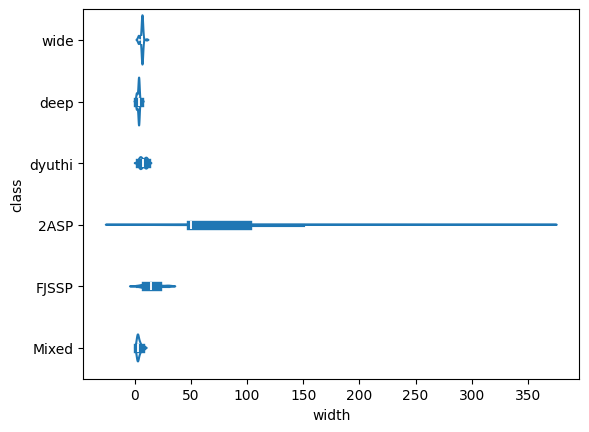

In [96]:
def dic_union(dict1, dict2):
    """
    Mearge values of two dictionaries
    """
    merged_dict = {**dict1, **dict2}
 
    for key, value in merged_dict.items():
        merged_dict[key] = dict1.get(key, []) + dict2.get(key, [])
    return merged_dict

dict = get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/ASP-WIDE/', filter="*No*.json", class_label="wide")

aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/ASP-DEEP/', filter="*No*.json", class_label="deep")
dict = dic_union(dict, aux_dict)

aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/dyuthi/',filter="*.json", class_label="dyuthi")
dict = dic_union(dict, aux_dict)

aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/2ASP/', filter="*.json", class_label="2ASP")
dict = dic_union(dict, aux_dict)

aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/FJSSP-Hurink-vdata/', class_label="FJSSP")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/FJSSP/set1/', filter="*No*.json", class_label="FJSSP")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/FJSSP/set2/', filter="*No*.json", class_label="FJSSP")
dict = dic_union(dict, aux_dict)


aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set1/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set2/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set3/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set4/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set5/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set6/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)
aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/mixed_boms/set7/', filter="*No*.json", class_label="Mixed")
dict = dic_union(dict, aux_dict)

aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/fajsp/out-dafjs/', filter="*.json", class_label="dafjs")
dict = dic_union(dict, aux_dict)

aux_dict=get_infomation_for_violin_graph(input_path=f'{dataset_path_dir}/fajsp/out-yfjs/', filter="*.json", class_label="yfjs")
dict = dic_union(dict, aux_dict)


import seaborn as sns
    
data_frame = pd.DataFrame(dict)
#print(data_frame)

sns.violinplot(data=data_frame, x="width", y="class", fill=False)


<Axes: xlabel='depth', ylabel='class'>

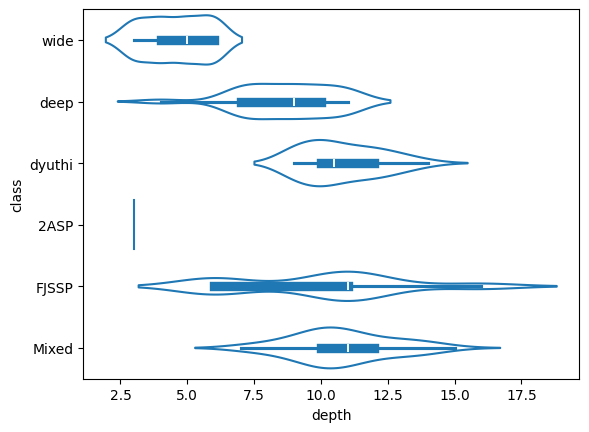

In [97]:
sns.violinplot(data=data_frame, x="depth", y="class",  fill=False)

<Axes: xlabel='width', ylabel='class'>

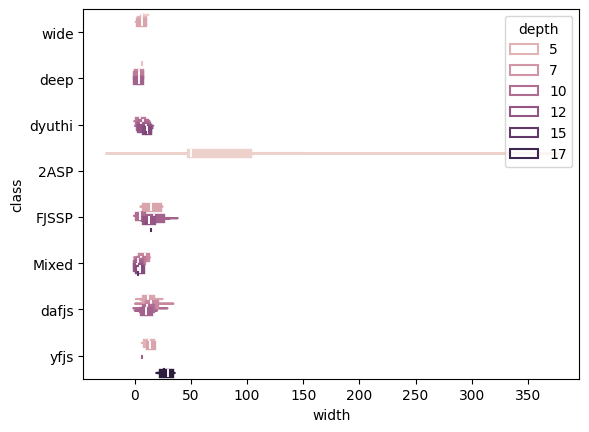

In [82]:
sns.violinplot(data=data_frame, x="width", y="class", hue="depth", fill=False)